In [228]:
import overpy
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
import pandas as pd
from geopy.distance import great_circle
from shapely import geometry
from shapely.geometry import MultiPoint, Polygon
from matplotlib.collections import PathCollection
import smopy
import folium
import fiona
import geopandas as gpd
from shapely.ops import cascaded_union, polygonize
from geopy.geocoders import Nominatim

In [2]:
api = overpy.Overpass()
r = api.query("""
(node['shop'](28.4844,77.0231,28.8188,77.6617);
 way['shop'='mall'](28.4844,77.0231,28.8188,77.6617);
 rel['shop'='mall'](28.4844,77.0231,28.8188,77.6617);
);
out center;
""")

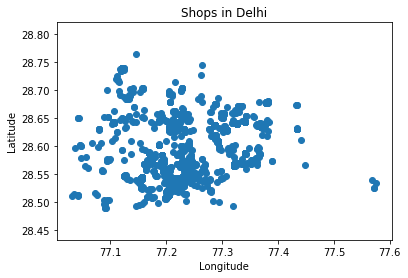

In [5]:
coords = []
for element in r.nodes:
    lon = element.lon
    lat = element.lat
    coords.append([float(lon), float(lat)])
X = np.array(coords)
plt.plot(X[:, 0], X[:, 1], 'o')
plt.title('Shops in Delhi')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.axis('equal')
plt.show()

In [6]:
db = DBSCAN(eps=0.1/6371., min_samples=5, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))

In [7]:
df = pd.DataFrame(coords,columns=['lon','lat'])
coords = df.as_matrix(columns=['lon','lat'])

C:\Users\sulay\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [8]:
cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))
print(cluster_labels)
print(num_clusters)
print(set(cluster_labels))

[-1  0 -1 ... 49 49 49]
61
{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, -1}


In [9]:
clusters = pd.Series([coords[cluster_labels == n] for n in range(0,num_clusters)])
print(clusters)
count = []
cluster_no = []
for i in range(num_clusters):
    count.append(len(clusters[i]))
    if(len(clusters[i])>10):
        cluster_no.append(i)
print(count)
print(cluster_no)

0     [[77.3696585, 28.633824], [77.3693275, 28.6340...
1     [[77.1564983, 28.542428], [77.1558025, 28.5416...
2     [[77.2195414, 28.5290541], [77.2167338, 28.528...
3     [[77.3759993, 28.6371575], [77.3758233, 28.639...
4     [[77.2354195, 28.6567331], [77.2359416, 28.656...
                            ...                        
56    [[77.4342066, 28.6307005], [77.4341286, 28.630...
57    [[77.3264368, 28.6393802], [77.326788, 28.6393...
58    [[77.340948, 28.6425384], [77.3407756, 28.6426...
59    [[77.3696676, 28.6397276], [77.3697929, 28.639...
60                                                   []
Length: 61, dtype: object
[14, 76, 76, 5, 7, 11, 90, 5, 8, 26, 44, 10, 20, 6, 6, 6, 38, 7, 9, 11, 361, 45, 5, 8, 10, 6, 7, 5, 10, 8, 17, 15, 5, 6, 7, 8, 24, 6, 8, 11, 132, 22, 5, 6, 12, 19, 14, 4, 5, 9, 12, 6, 15, 5, 8, 29, 8, 16, 10, 11, 0]
[0, 1, 2, 5, 6, 9, 10, 12, 16, 19, 20, 21, 30, 31, 36, 39, 40, 41, 44, 45, 46, 50, 52, 55, 57, 59]


In [10]:
color = db.labels_
for i in range(len(color)):
    if color[i] == -1:
        color[i]=0
    else:
        color[i]=1
print(color)

[0 1 0 ... 1 1 1]


In [11]:
clusters = clusters[0:num_clusters-1]

In [12]:
def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)
centermost_points = clusters.map(get_centermost_point)

In [272]:
lons, lats = zip(*centermost_points)
rep_points = pd.DataFrame({'lon':lons, 'lat':lats})
#rs = rep_points.apply(lambda row: df[(df['lat']==row['lat'])(df['lon']==row['lon'])].iloc[0], axis=1)

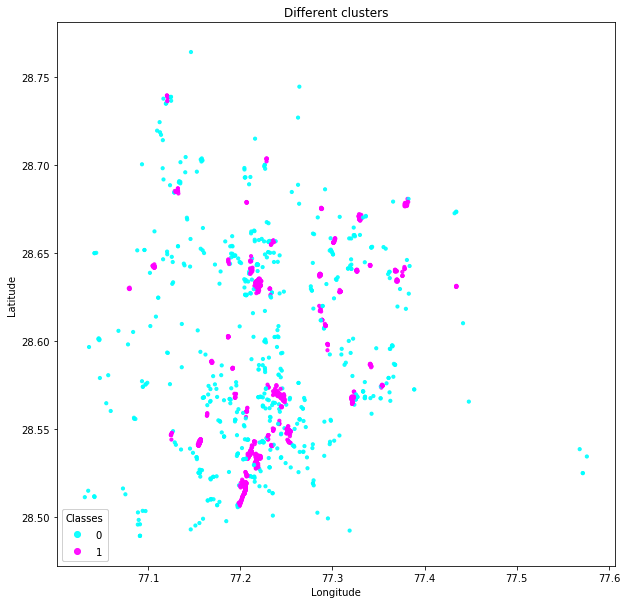

In [14]:
fig, ax = plt.subplots(figsize=[10, 10])
#rs_scatter = ax.scatter(rep_points['lon'], rep_points['lat'], c='#99cc99', edgecolor='None', alpha=0.7, s=120)
df_scatter = ax.scatter(df['lon'], df['lat'], c=color, alpha=0.9, s=10, cmap='cool')
ax.set_title('Different clusters')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
legend1 = ax.legend(*df_scatter.legend_elements(),loc="lower left", title="Classes")
ax.add_artist(legend1)
plt.show()

In [172]:
map = smopy.Map((28.4844,77.0231,28.8188,77.6617), z=11)

In [16]:
x, y = map.to_pixels(df['lat'],df['lon'])

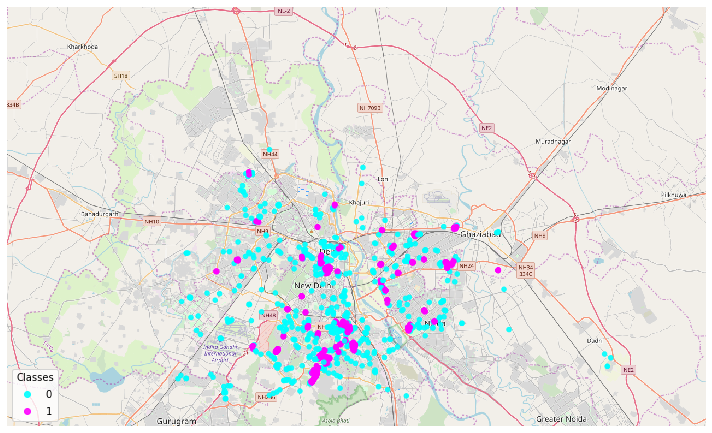

In [17]:
ax = map.show_mpl(figsize=(10, 10))
ax.scatter(x, y, c=color, alpha=0.9, s=20, cmap='cool')
legend1 = ax.legend(*df_scatter.legend_elements(),loc="lower left", title="Classes")
#ax.plot(x,y,'or', ms=10, mew=2)

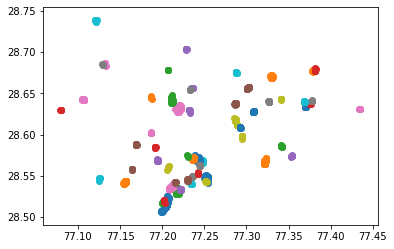

In [282]:
geo = []
name = []
geolocator = Nominatim(user_agent="specify_your_app_name_here")
for i in range(len(r.ways)):
    coords = []
    way = r.ways[i]
    nodes = way.get_nodes(resolve_missing=True)
    try:
        try:
            name.append(way.tags['name:en'])
        except:
            name.append(way.tags['name'])
    except:
        name.append('')
    for element in nodes:
        lon = element.lon
        lat = element.lat
        coords.append([float(lon), float(lat)])
    point_collection = geometry.MultiPoint(coords)

    convex_hull_polygon = point_collection.convex_hull
    geo.append(convex_hull_polygon)
    
for i in range(num_clusters-1):
    flag = 0
    lon_point_list = []
    lat_point_list = []
    for j in range(len(clusters[i])):
        lon_point_list.append(clusters[i][j][0])
        lat_point_list.append(clusters[i][j][1])
    plt.scatter(lon_point_list,lat_point_list)
    points=clusters[i]

    point_collection = geometry.MultiPoint(points)

    convex_hull_polygon = point_collection.convex_hull
    
    for j in range(len(geo)):
        if convex_hull_polygon.intersects(geo[j]):
            flag = 1
            break
    if flag==0:
        geo.append(convex_hull_polygon)
        if i in cluster_no:
            location = geolocator.reverse(str(rep_points['lat'][i]) + ',' + str(rep_points['lon'][i]))
            temp = location.address.split(', ')
            name.append(temp[1] + ' market')
        else:
            name.append('')

In [274]:
index = np.arange(0,len(geo))

In [275]:
dataframe = pd.DataFrame(name,columns=['name'])
dataframe['name']=dataframe['name'].astype(str)

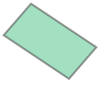

In [276]:
crs = {'init' :'epsg:4326'}
polygon = gpd.GeoDataFrame(dataframe, crs=crs, geometry=geo, columns=['name']) 
polygon.geometry[5]

In [277]:
#polygon_geom = Polygon(zip(lon_point_list, lat_point_list))
#crs = {'init': 'epsg:4326'}
#polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
#print(polygon.geometry)

polygon.to_file(filename='polygon.geojson', driver='GeoJSON')
polygon.to_file(filename='polygon.shp', driver="ESRI Shapefile")

In [194]:
m = folium.Map([lat_point_list[0],lon_point_list[0]], zoom_start=18)
folium.GeoJson('polygon.geojson',name='geojson').add_to(m)
folium.LatLngPopup().add_to(m)
m

In [279]:
m = folium.Map([lat_point_list[0],lon_point_list[0]], zoom_start=18)
#folium.GeoJson('polygon.geojson',name='geojson').add_to(m)
folium.GeoJson('polygon.geojson',
               name='Commercial Markets and Centers',
               style_function=lambda x: {'weight':5,'color':'blue','dashArray':'1 3'},
               highlight_function=lambda x: {'weight':5,'color':'yellow', 'dashArray':'1 7'},
               tooltip=folium.features.GeoJsonTooltip(fields=['name']),
               smooth_factor=5.0,
              ).add_to(m)
folium.LatLngPopup().add_to(m)
m